# Product Order Demand Forecast
This project implements a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model to forecast product demand for a global manufacturing company. Using historical order data, the model analyzes seasonal patterns to predict future order volumes, which is crucial for optimizing inventory and supply chain decisions.

---
## 1. Exploratory Data Analysis
Before applying a forecasting model, it's essential to perform exploratory data analysis (EDA) to understand the features within the dataset.

### 1.1 Understand our dataset

In [2]:
# Import our libraries for further use
import numpy as np
import pandas as pd

## Visualization
from matplotlib import pyplot as plt
from matplotlib import rcParams
from statsmodels.api import qqplot
import seaborn as sns

# Time series package
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load .csv dataset into DataFrame
data = pd.read_csv('Historical Product Demand.csv',parse_dates=['Date'])
df = pd.DataFrame(data)

Below is an overview of the newly loaded DataFrame.

In [69]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [70]:
# See how many columns and rows
df.shape

(1048575, 5)

In [71]:
# Check missing values
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [72]:
df.describe()

,Date,Order_Demand
count,1037336,1.048575e+06
mean,2014-06-17 05:14:07.756175104,4.867427e+03
min,2011-01-08 00:00:00,-9.990000e+05
25%,2013-04-05 00:00:00,1.800000e+01
50%,2014-06-10 00:00:00,3.000000e+02
75%,2015-08-26 00:00:00,2.000000e+03
max,2017-01-09 00:00:00,4.000000e+06
std,NaN,2.893346e+04


In [73]:
# Check data types
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

The initial check reveals a significant number of missing values in the `Date` column. Although the `parse_dates` parameter correctly converted the column to a datetime format upon loading, these missing values must be addressed before proceeding with the analysis.

### 1.2 Data preprocessing

#### Handle missing values and format the dataset

As we saw earlier, there are many missing values in `Date` column. To make sure there is no significant change in our result if we remove those ones, I will calculate the percentage of missing values in this column.

In [74]:
# Calculate the percentage of missing values in 'Date' column
missing_count = df['Date'].isna().sum()
total_count = len(df)
missing_percentage = round(((missing_count/total_count) * 100),2)
print(missing_percentage)

1.07


Since the missing values in the `Date` column account for only about 1% of the dataset, dropping these rows should not significantly impact the analysis. In this step, rows with missing dates are removed, and the DataFrame is sorted chronologically.

In [75]:
df.dropna(inplace=True)

df = df.sort_values('Date', ascending=True)

In [76]:
df.head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
17249,Product_0608,Whse_C,Category_001,2011-09-27,5
17250,Product_1933,Whse_C,Category_001,2011-09-27,23
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450
131426,Product_0125,Whse_S,Category_011,2011-10-20,-2
131429,Product_0412,Whse_S,Category_007,2011-10-20,-2


#### Check the distribution of `Order Demand`

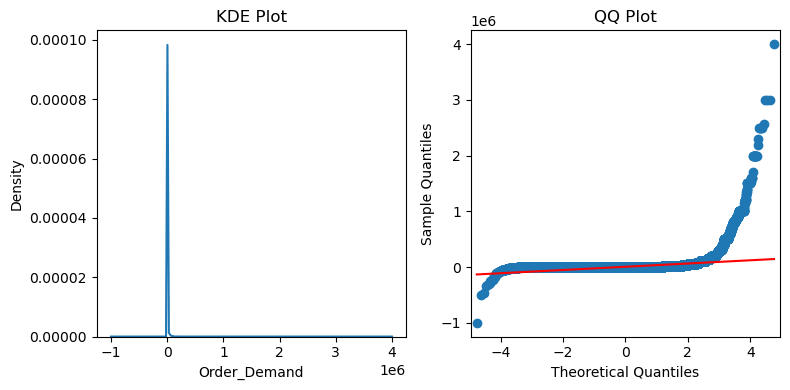

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(data=df['Order_Demand'],ax=axes[0])
axes[0].set_title('KDE Plot')
qqplot(data=df['Order_Demand'],line='s', ax=axes[1])
axes[1].set_title('QQ Plot')
plt.tight_layout()

In [78]:
df['Order_Demand'].skew()

31.30471548562553

The KDE and QQ plots indicate that the Order_Demand distribution is heavily right-skewed.

### 1.3 Univariate analysis 

#### `Warehouse` analysis

In [79]:
df_warehouse = df.groupby('Warehouse')['Order_Demand'].sum().reset_index()
df_warehouse.sort_values('Order_Demand',ascending=False,inplace=True)

df_warehouse # J has the most orders and A has the least

,Warehouse,Order_Demand
2,Whse_J,3344521718
3,Whse_S,1034227618
1,Whse_C,581845212
0,Whse_A,143257683


#### `Product Category` analysis

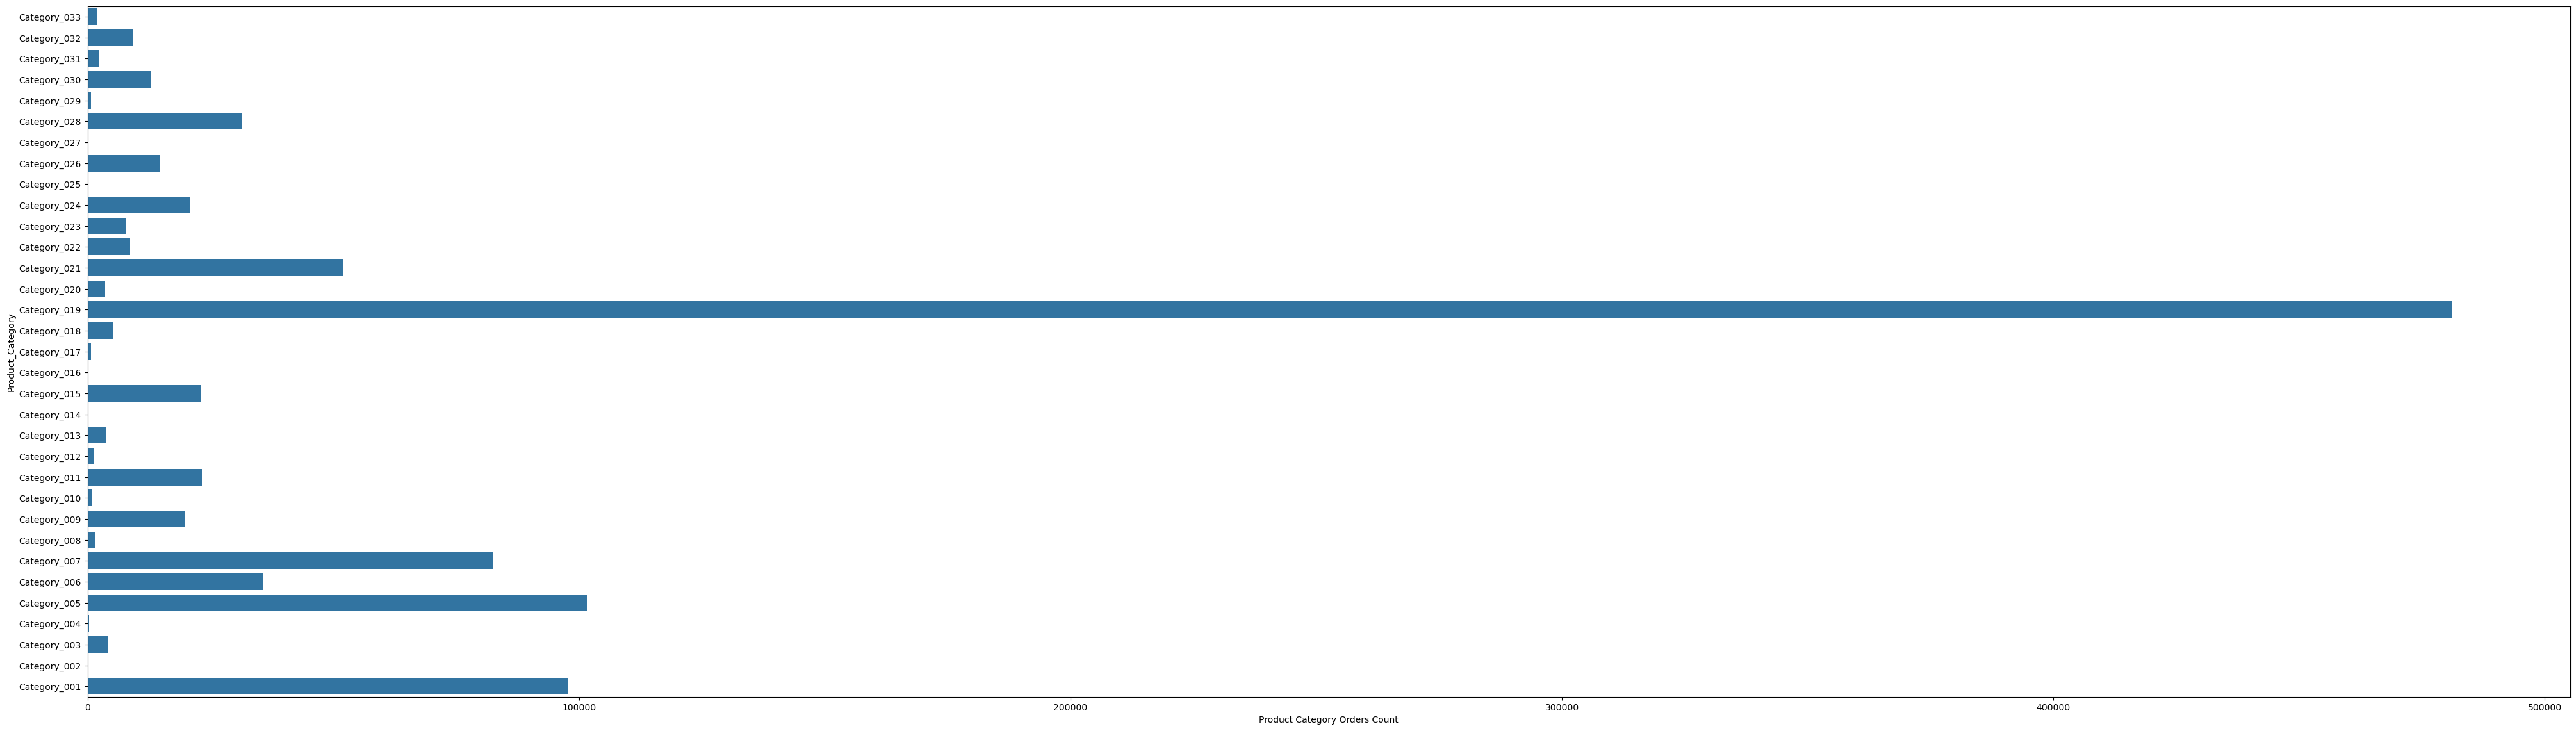

In [4]:
rcParams['figure.figsize'] = 50,14
sns.countplot(data=df['Product_Category'].sort_values(ascending=False))
plt.xlabel('Product Category Orders Count')
plt.show()
# There are a lot of orders in category_19

### 1.4 Bivariate analysis

#### `Warehouse` with `Order Demand` analysis

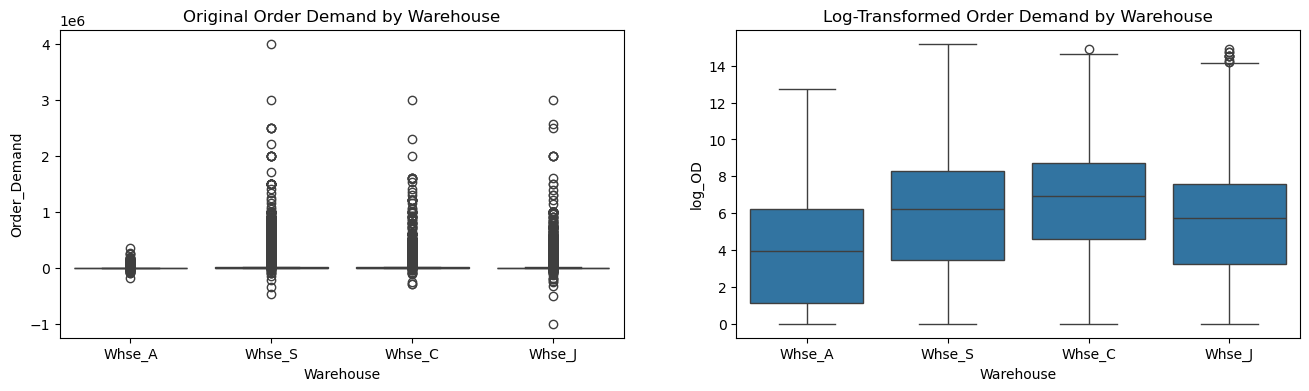

In [81]:
df['log_OD'] = np.log1p(df['Order_Demand'].clip(lower=0)) # log(1+x) doesn't accept negative values
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)

sns.boxplot(data=df, x='Warehouse', y='Order_Demand', ax=axes[0])
axes[0].set_title('Original Order Demand by Warehouse')

sns.boxplot(data=df, x='Warehouse', y='log_OD', ax=axes[1])
axes[1].set_title('Log-Transformed Order Demand by Warehouse')
plt.show()

#### `Product category` with `Order Demand` analysis

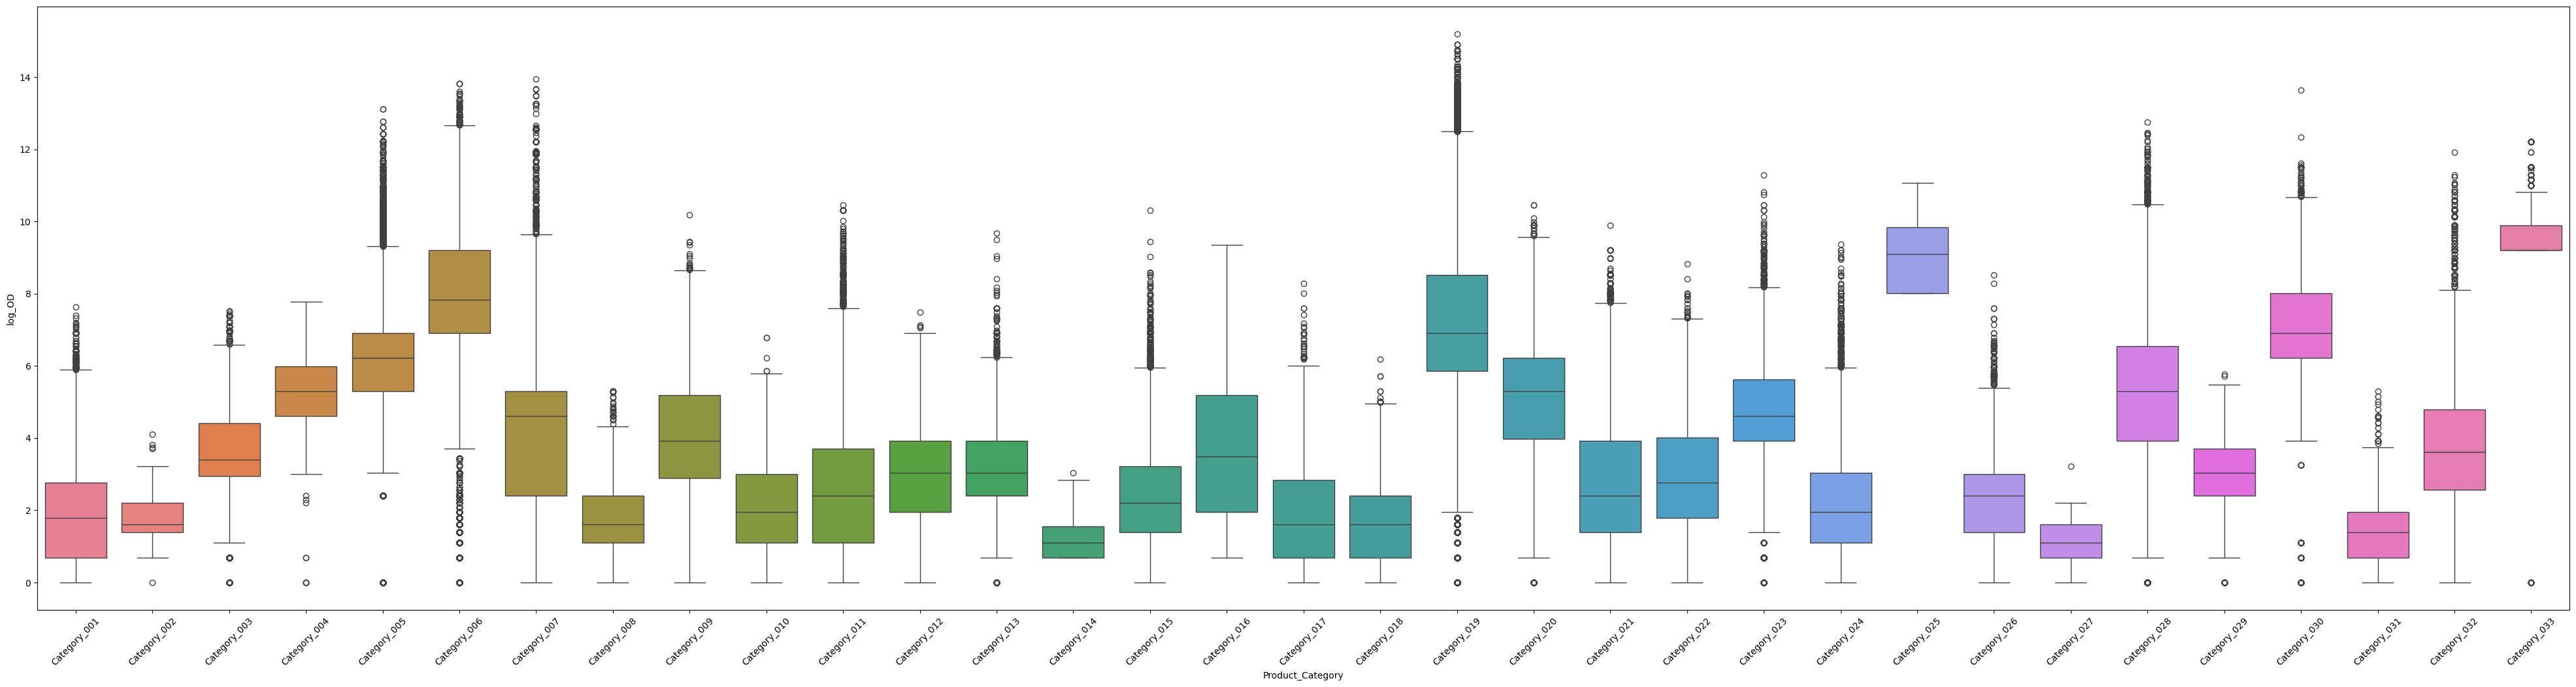

In [82]:
rcParams['figure.figsize'] = 50,12

sns.boxplot(data=df.sort_values('Product_Category'), x='Product_Category', y='log_OD',hue='Product_Category',legend=False)
plt.xticks(rotation=45)
plt.show()

## 2. Time Series Analysis

### 2.1 Explore the data as time series

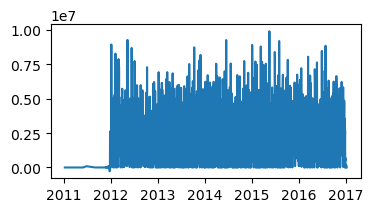

In [27]:
# Checking the 
df_ts = df.copy()
df_ts = df_ts.groupby('Date')['Order_Demand'].sum().reset_index()
df_ts = df_ts.set_index('Date')

# Plot the initial time series data
rcParams['figure.figsize'] = 4,2
plt.plot(df_ts['Order_Demand'])
plt.show()

From the visualization, there are a lot of inconsistent and insignificant values in 2011. Hence, for a better fitting model, we will limit our data range values from the first day of 2012 to the last day of 2016.

In [51]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df.set_index('Date',inplace=True)
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [6]:
y = df['Order_Demand'].resample('MS').mean() # Resample by month

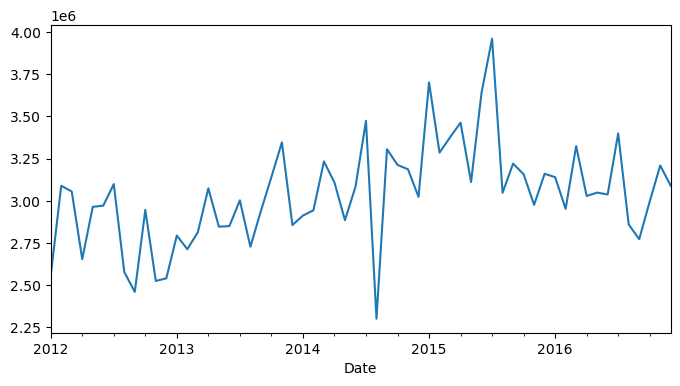

In [5]:
# Visualization after resampling
y.plot(figsize=(8,4))
plt.show()

### 2.2 Decompose the time series

Next, the time series is decomposed into its core components: trend, seasonality, and residuals. Based on the visualization, the seasonal fluctuations appear to be relatively constant over time, suggesting that an additive model is the appropriate choice for decomposition.

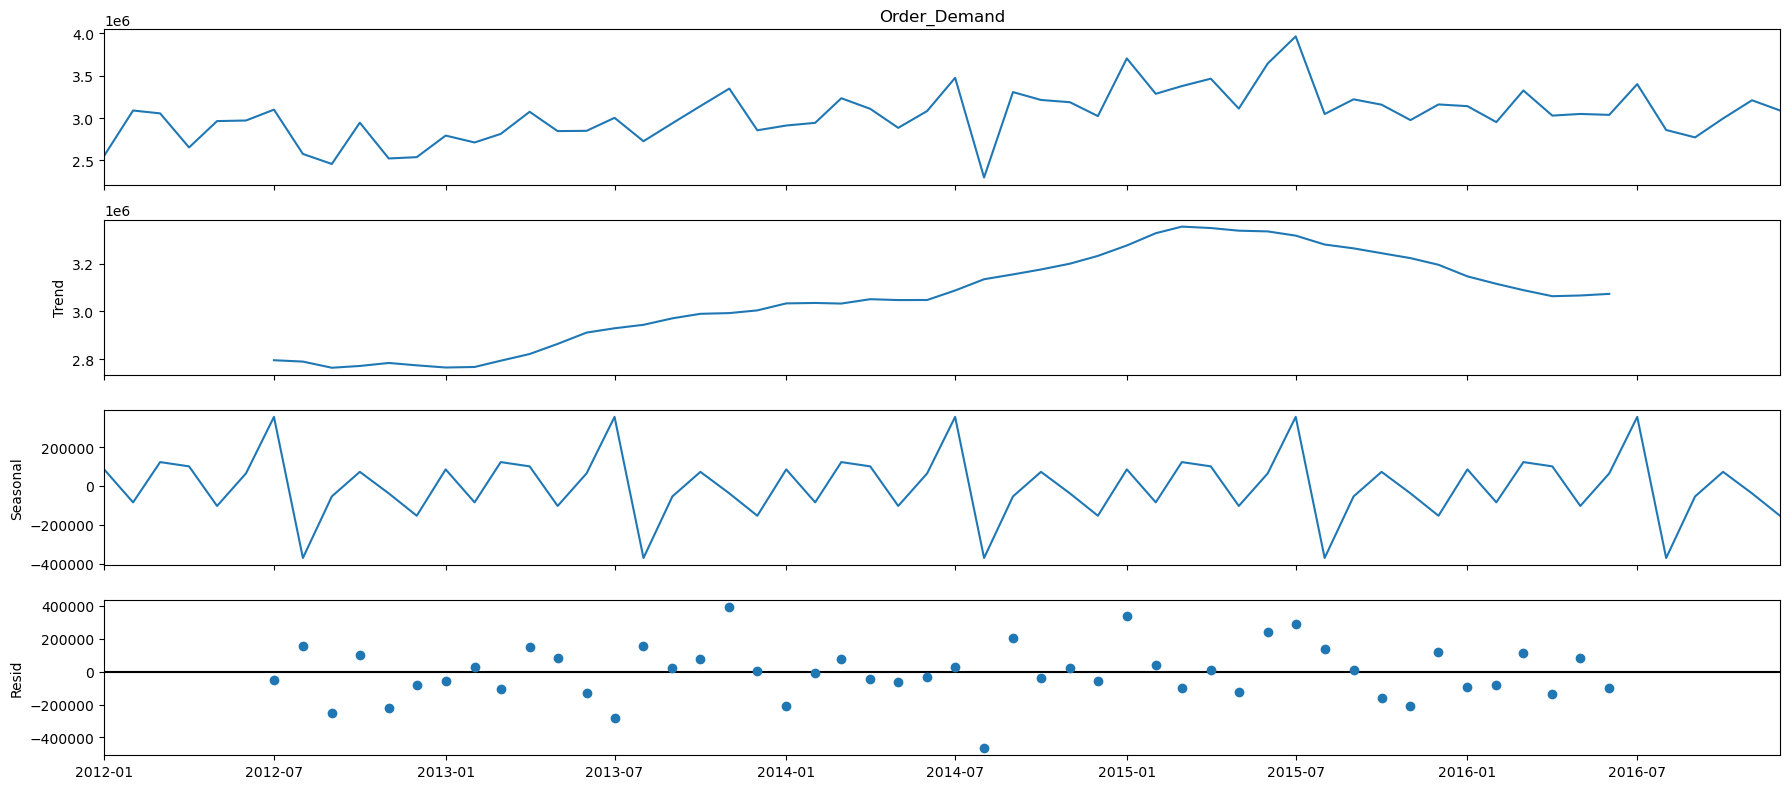

In [37]:
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(y,model='additive') # Initial guess from the time series plot
decomposition.plot()
plt.show()

The decomposition plot shows that the residuals are random noise with no discernible patterns, confirming the suitability of the additive model. The data exhibits a clear seasonal pattern that repeats every 12 months, making the **SARIMA (Seasonal AutoRegressive Integrated Moving Average)**  model an excellent candidate for forecasting.

### 2.3 Choose the best hyperparameters 

The SARIMA model is defined by seven parameters: three non-seasonal components (p, d, q) and four seasonal components (P, D, Q, s). The time series decomposition revealed a seasonal period (s) of 12 months. This leaves six parameters to be optimized for the best model performance.

To select the best combination of parameters, we will use the **Akaike Information Criterion (AIC)**. AIC is a valuable metric for balancing a model's goodness-of-fit with its complexity. The objective is to perform a grid search to identify the parameter set that yields the lowest AIC score, which will then be used for model fitting.

In [24]:
import itertools
import warnings
warnings.filterwarnings("ignore") # For ignore the warning while fitting the model

p = d = q = range(0, 2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
param_aic = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            result = model.fit(disp=False)
            param_aic[(param, param_seasonal)] = result.aic
        except:
            continue
min_aic_key = min(param_aic, key=param_aic.get)
min_aic_value = param_aic[min_aic_key]

print(f'Best SARIMAX parameters: {min_aic_key} --- AIC value: {min_aic_value}')

Best SARIMAX parameters: ((1, 1, 1), (1, 1, 0, 12)) --- AIC value: 960.4017832654683


### 2.4 Fit the model and plot the diagnostics

In [19]:
model = SARIMAX(y,order=(1,1,1),
                seasonal_order=(1,1,0,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit(disp=False)

print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2900      0.373     -0.778      0.437      -1.021       0.441
ma.L1         -0.4086      0.329     -1.242      0.214      -1.054       0.236
ar.S.L12      -0.4405      0.205     -2.148      0.032      -0.843      -0.039
sigma2      1.019e+11   8.33e-13   1.22e+23      0.000    1.02e+11    1.02e+11


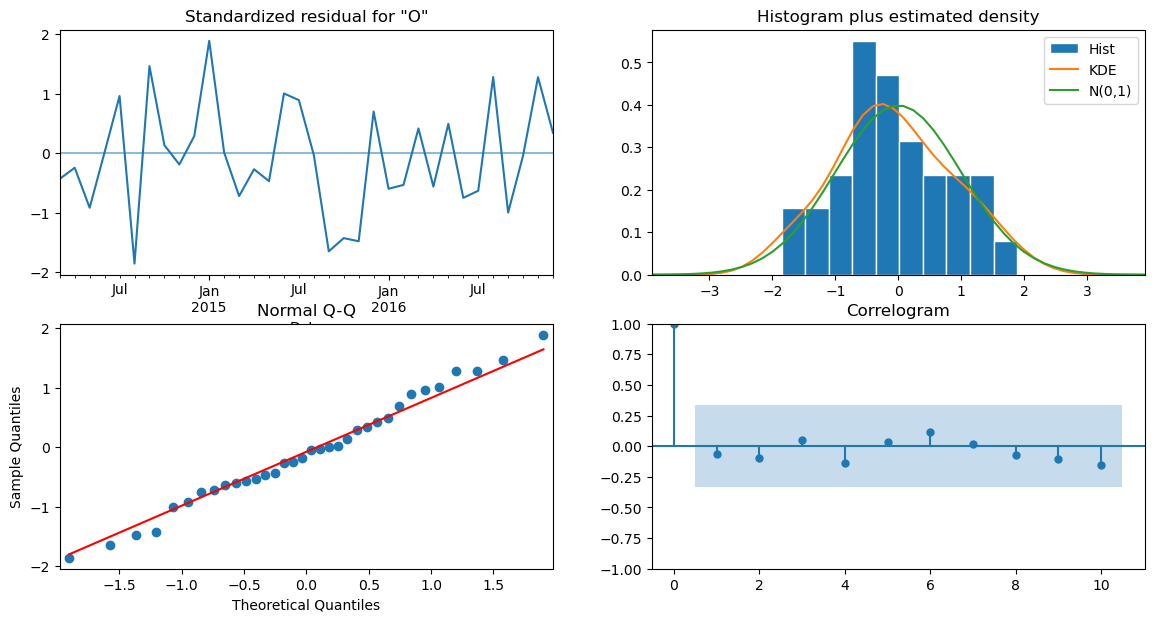

In [23]:
result.plot_diagnostics(figsize=(14, 7))
plt.show()

## 3. Time Series Forecasting

### 3.1 In-sample forecast

In [16]:
# Load model
model = SARIMAX(y,order=(1,1,1),
                seasonal_order=(1,1,0,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit(disp=False)

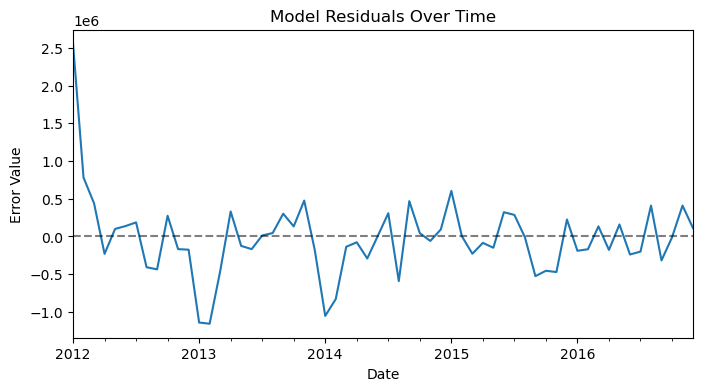

In [19]:
rcParams['figure.figsize'] = 8, 4

# Check model residuals after fitting
residuals = result.resid
residuals.plot()
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.title('Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Error Value')

plt.show()

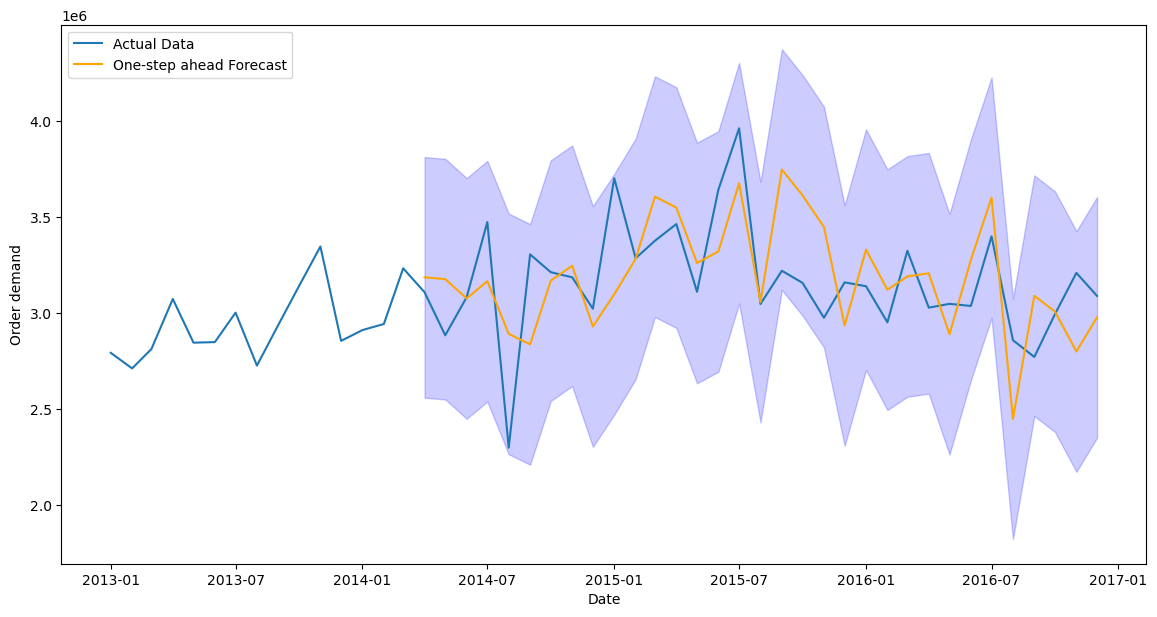

In [39]:
rcParams['figure.figsize'] = 14, 7

# Get prediction
predict = result.get_prediction(start=pd.to_datetime('2014-04-01'), dynamic=False) # In-sample forecast
predictions = predict.predicted_mean
pred_ci = predict.conf_int()

# Plotting the the forecast and actual data
plt.plot(y['2013':], label='Actual Data')
plt.plot(predictions.index, predictions, label='One-step ahead Forecast', color='orange')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1],color='blue', alpha=.2)
plt.xlabel('Date')
plt.ylabel('Order demand')
plt.legend()

plt.show()

### 3.2 Model Evaluation

#### Root Mean Squared Error (RMSE)
RMSE measures the standard deviation of the residuals (prediction errors). It is a useful metric because the error is expressed in the same units as the original data (Order_Demand), making it easier to interpret.

In [37]:
# Import MSE from sklearn library
from sklearn.metrics import mean_squared_error

rmse = lambda a,b : np.sqrt(mean_squared_error(a,b))
RMSE = rmse(y['2014-04-01':],predictions)

round(RMSE,2)

293623.02

#### Mean Absolute Error (MAE)
MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It provides a straightforward measure of the average forecast error.

In [38]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y['2014-04-01':],predictions)
round(mae,2)

237498.6

#### Mean Absolute Percentage Error (MAPE)
MAPE expresses the average absolute error as a percentage of the actual values. This makes it a useful relative metric for understanding the scale of the error.

In [32]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mape(y['2014-04-01':],predictions)
round(mape,2)

7.63

### 3.3 Out-of-sample forecast
With the model evaluated, the final step is to forecast future values beyond the historical data. Here, we generate a forecast for the next five years (60 months) to predict future product demand.

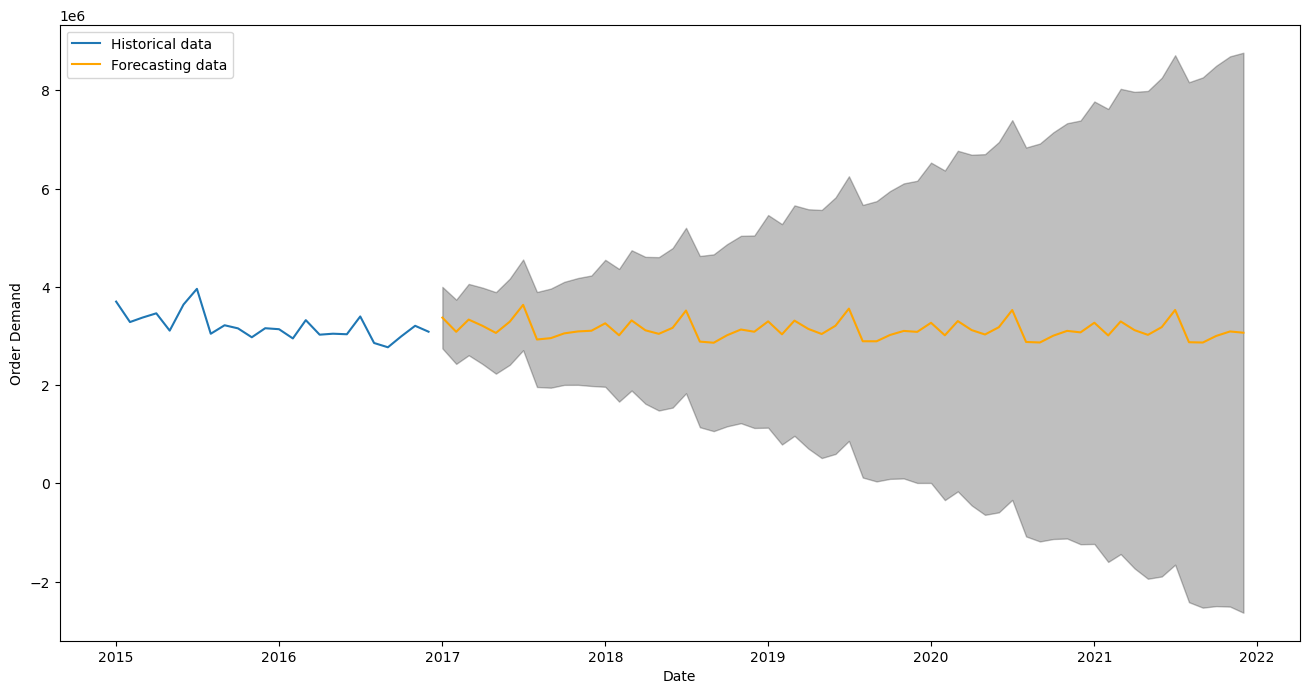

In [42]:
# Get the forecast for the next 5 years
forecast = result.get_forecast(steps=60) # Next 5 years
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()   # Should be larger after time because of uncertainty

rcParams['figure.figsize'] = 16, 8

# Plot the forecasting data 
plt.plot(y['2015':],label='Historical data')
plt.plot(forecast_mean,label='Forecasting data',color='orange')
plt.fill_between(forecast_ci.index,forecast_ci.iloc[:,0],forecast_ci.iloc[:,1],color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()

plt.show()

In [47]:
# Try to forecast the order demand in January of 2021 
round(forecast_mean['2021-01-01'],2)

3271344.3